In [3]:
import baltic as bt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import time
from io import StringIO
import altair as alt
from altair import datum
import arviz as az
from scipy.stats import gaussian_kde

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
trees =  "/Users/mparedes/Desktop/mpox_rhino/300_skygrid_country_mcc.trees"


In [4]:
def get_taxa_lines(tree_path):    
    # write out a temp tree file
#     temp_tree = tree_path.replace(".trees",".temp.tree")
#     with open(temp_tree, "w") as outfile: 
#         outfile.write("")

    lines_to_write = ""
    with open(trees, 'rU') as infile:
        for line in infile: ## iterate through each line
            if 'state' not in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                lines_to_write = lines_to_write + line

    return(lines_to_write)

In [5]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [6]:
#making decimal date from string dates adapted from stackoverflow (thank you coding geniuses)
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [7]:
def enumerate_migration_events(tree, traitType):
        
    output_dict = {}
    migration_events_counter = 0
        
    for k in tree.Objects:
        trait = k.traits[traitType]
        parent_node = k.parent
        
        if traitType not in parent_node.traits:
            parent_trait = "root"
        
        # only write out migration events that are not from root to deme
        else:
            parent_trait = parent_node.traits[traitType]
        
            if trait != parent_trait:
                migration_events_counter += 1

                migration_event = parent_trait + "-to-" + trait
                #migration_date = parent_node.absoluteTime                

                # write to output dictionary
                output_dict[migration_events_counter] = {"type":migration_event, #"date":migration_date,
                                                        "parent_host":parent_trait,
                                                        "child_host": trait}
    
    return(output_dict)

In [12]:
all_trees = trees
burnin_percent = 0.1
taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_7437/3838516127.py:8: DeprecationWarning: 'U' mode is deprecated
  with open(trees, 'rU') as infile:
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_7437/173367558.py:2: DeprecationWarning: 'U' mode is deprecated
  with open(tree_path, 'rU') as infile:


600.0


In [8]:
#counts all migration events and records parent and child nodes
def run_mig_counts(all_trees, traitType):
    start_time = time.time()

    with open(all_trees, "r") as infile:

        tree_counter = 0
        trees_processed = 0
        migrations_dict = {}

        for line in infile:
            if 'tree STATE_' in line:
                tree_counter += 1

                if tree_counter > burnin:
                    temp_tree = StringIO(taxa_lines + line)
                    tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                    tree.setAbsoluteTime(2023.0068)
                    trees_processed += 1

                    # iterate through the tree and pull out all migration events
                    migrations_dict[tree_counter] = enumerate_migration_events(tree, traitType)

    # print the amount of time this took
    total_time_seconds = time.time() - start_time
    total_time_minutes = total_time_seconds/60
    print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
   
    """this will generate a multi-index dataframe from the migrations dictionary"""
    migrations_df = pd.DataFrame.from_dict({(i,j): migrations_dict[i][j] 
                           for i in migrations_dict.keys() 
                           for j in migrations_dict[i].keys()},
                       orient='index')

    migrations_df.reset_index(inplace=True)
    migrations_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
    
    return(migrations_df)

In [14]:
migrations_df = run_mig_counts(all_trees, traitType ="country")

this took 220.12085700035095 seconds ( 3.6686809500058493  minutes) to run on 5400 trees


In [15]:
#separate out into exports and imports
imports = migrations_df.groupby(["child_host", "tree_number"])['migration_event_number'].count().reset_index()
exports = migrations_df.groupby(["parent_host", "tree_number"])['migration_event_number'].count().reset_index()
imports.index = imports.child_host
exports.index = exports.parent_host

In [17]:
#create a migration dictionary 
mig_dict_imports={x:[] for x in imports["child_host"].unique()}
mig_dict_exports={x:[] for x in exports["parent_host"].unique()}

for items in imports.index.unique():
    mig_dict_imports[items].append(imports.loc[items,"migration_event_number"].values)
    mig_dict_exports[items].append(exports.loc[items,"migration_event_number"].values)

In [5]:
imports

NameError: name 'imports' is not defined

In [19]:
colors = {"Canada":"#133253",
          "USA":"#2664A5",
        
          
          # greens
          "UnitedKingdom":"#1C3828",
          "Germany":"#356D4C",
          "Switzerland":"#81A48F",
          "Austria":"#B3C8BC",
          "France":"#CCDAD2",

          "Belgium":"#438B62",
          #"Netherlands":"#60B684",

          
          # yellows
          "Slovakia":"#D0A854",
          "Slovenia":"#EEC060",

          
          # oranges
          "Italy":"#D07954",
          "Portugal":"#EEA160",
          "Spain":"#F4C49C",
          
          # purples
          "Colombia":"#2D1E45",
          "Peru":"#695B82",
          "ancestor":'grey'

          
          # reds

          #"Finland":"#C5656E"
         }


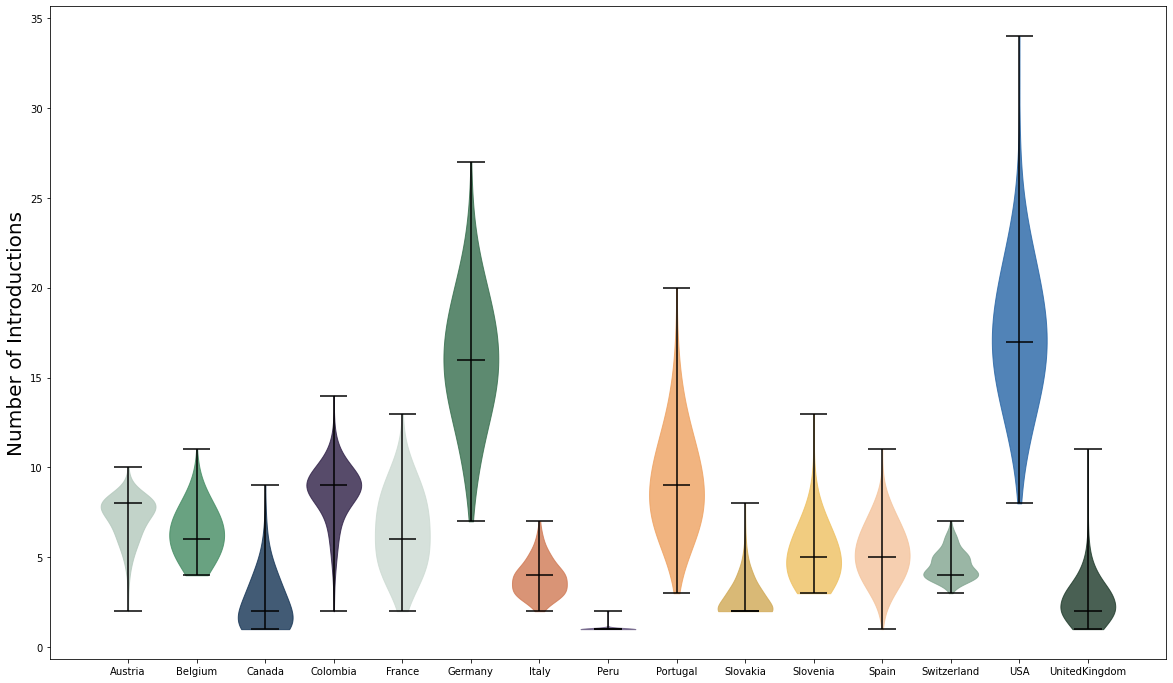

In [20]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(mig_dict_imports.keys()):
    

    violin_plot = axs.violinplot(mig_dict_imports[place], positions =[index], widths=0.8,
                      showmedians=True, bw_method=0.6)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmins"].set_edgecolor("black")
    violin_plot["cmaxes"].set_edgecolor("black")
    violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

countries = list(mig_dict_imports.keys())
axs.set_xticks(pos)
axs.set_xticklabels(countries)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Number of Introductions", size=20)
plt.savefig('../figures/dta_country_intros.png',dpi=300,bbox_inches='tight')


plt.show()
    


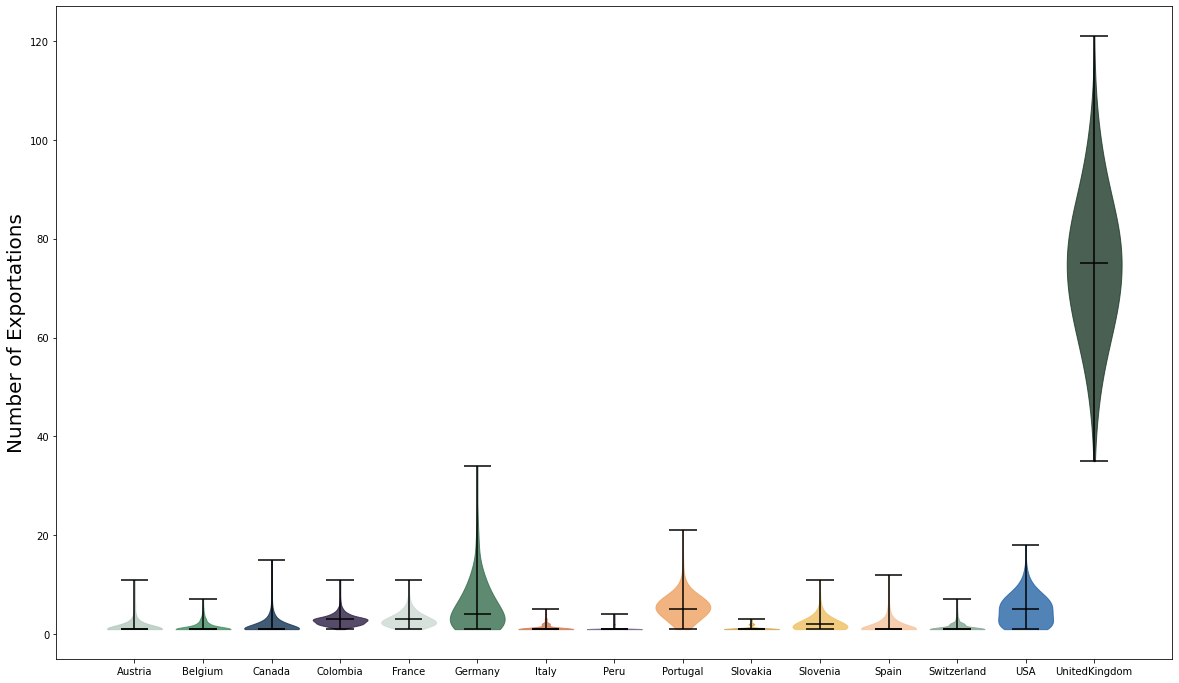

In [21]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(mig_dict_exports.keys()):
    

    violin_plot = axs.violinplot(mig_dict_exports[place], positions =[index], widths=0.8,
                      showmedians=True, bw_method=0.5)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmins"].set_edgecolor("black")
    violin_plot["cmaxes"].set_edgecolor("black")
    violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

countries = list(mig_dict_exports.keys())
axs.set_xticks(pos)
axs.set_xticklabels(countries)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Number of Exportations", size=20)
plt.savefig('../figures/dta_country_exports.png',dpi=300,bbox_inches='tight')


plt.show()
    


### work on presistence times

In [9]:
#need to convert the decimal dates back to calendar dates 
def convert_persistence(number):

    
    d = timedelta(days=(number)*(365))
    
    return d.total_seconds()

In [10]:
#this is adapted from Bedford et al in nature where we start at a time and then walk backwards up the tree until the location changes
def estimate_persistence(tree, typeTrait):
        
    output_dict = {}
    persistence_counter = 0
        
    for k in tree.Objects:
        
        
        trait = k.traits[typeTrait]
        parent_node = k.parent
        if ('root' in parent_node.traits) or (parent_node.traits == {}) :
            parent_trait = "root"
        
        # only write out migration events that are not from root to deme
        elif k.branchType=='leaf':
            tip_date= k.absoluteTime
            tip_name = k.name
            confirm = True
            while confirm == True:
                try:
                    parent_trait = parent_node.traits[typeTrait]
                    
                    if trait != parent_trait:
                        persistence_counter += 1

                        migration_event = parent_trait + "-to-" + trait
                        migration_date = parent_node.absoluteTime
                        
                        persistence =  tip_date - migration_date

    
                        # write to output dictionary
                        output_dict[persistence_counter] = {"type":migration_event, "migration date":migration_date,"tip date": tip_date, "persistance": persistence, "tip_name" : tip_name,
                                                        "parent_host":parent_trait,
                                                        "child_host": trait}
                        confirm = False
                    else:    
                        parent_node = parent_node.parent    

                except:
                    break
                    

        else:
            continue
    
    return(output_dict)

In [27]:
start_time = time.time()

with open(trees, "r") as infile:
    
    tree_counter = 0
    trees_processed = 0
    persistence_dict = {}
    
    for line in infile:
       # print(line)
        if 'tree STATE_' in line:
            tree_counter += 1
            

            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                tree.setAbsoluteTime(2023.0068)
                trees_processed += 1

            # iterate through the tree and pull out all migration events
                persistence_dict[tree_counter] =  estimate_persistence(tree, "country")
            
# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
persistence_df = pd.DataFrame.from_dict({(i,j): persistence_dict[i][j] 
                           for i in persistence_dict.keys() 
                           for j in persistence_dict[i].keys()},
                       orient='index')

persistence_df
persistence_df.reset_index(inplace=True)
persistence_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
persistence_df.head(5)

this took 192.39534306526184 seconds ( 3.2065890510876973  minutes) to run on 5400 trees


,tree_number,migration_event_number,type,migration date,tip date,persistance,tip_name,parent_host,child_host
0,601,1,UnitedKingdom-to-Switzerland,2022.283265,2022.434197,0.150932,hMPXV-CH-38347314/2022_Switzerland_2022-06-08,UnitedKingdom,Switzerland
1,601,2,UnitedKingdom-to-USA,2022.353775,2022.379403,0.025628,MPXV_USA_2022_GA001_USA_2022-05-19,UnitedKingdom,USA
2,601,3,UnitedKingdom-to-Portugal,2022.463337,2022.623238,0.159902,Monkeypox/PT0515/2022_Portugal_2022-08-16,UnitedKingdom,Portugal
3,601,4,UnitedKingdom-to-Portugal,2022.463337,2022.631458,0.168121,Monkeypox/PT0527/2022_Portugal_2022-08-19,UnitedKingdom,Portugal
4,601,5,Germany-to-Italy,2022.331532,2022.384882,0.053350,INMI-Pt4_Italy_2022-05-21,Germany,Italy


In [28]:
persist = persistence_df.groupby(["child_host", "tree_number"])['persistance'].mean().reset_index()
persist['persistance'] = persist['persistance'].map(convert_persistence)
persist['persistance'] = persist['persistance'].div(86400) #calculating number of days from seconds
persist.index = persist.child_host


persist_dict={x:[] for x in persist["child_host"].unique()}

for items in persist.index.unique():
    persist_dict[items].append(persist.loc[items,"persistance"].values)
    


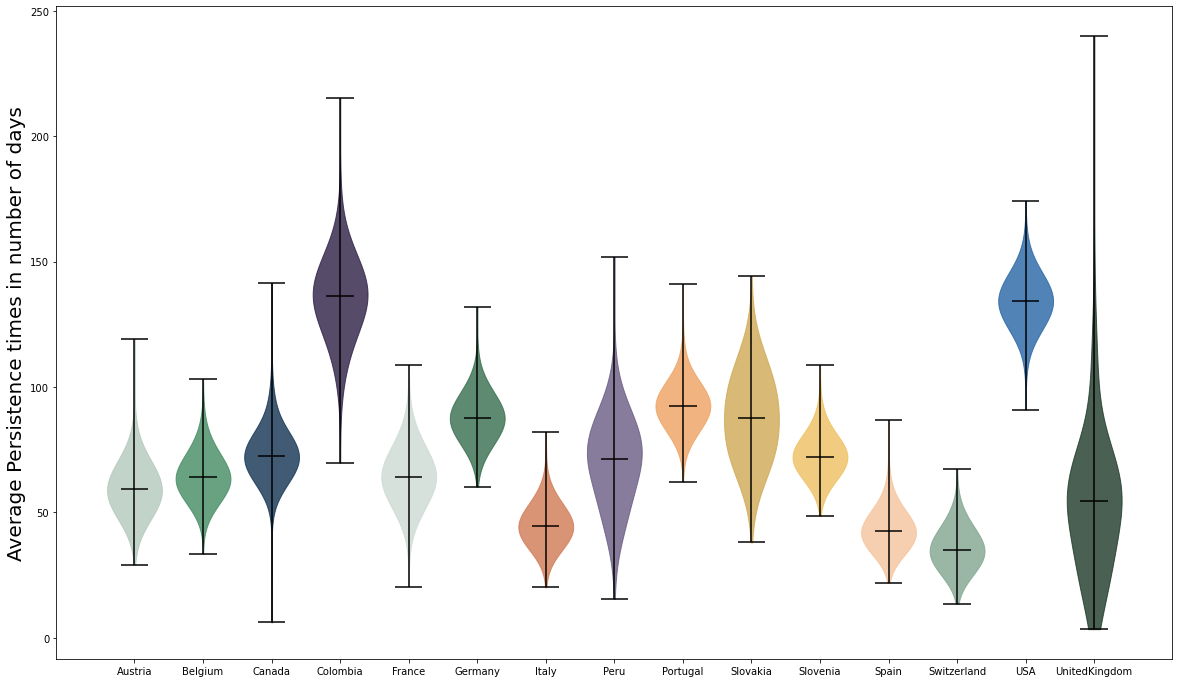

In [29]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(persist_dict.keys()):
    

    violin_plot = axs.violinplot(persist_dict[place], positions =[index], widths=0.8,
                      showmedians=True, bw_method=0.6)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmins"].set_edgecolor("black")
    violin_plot["cmaxes"].set_edgecolor("black")
    violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

countries = list(persist_dict.keys())
axs.set_xticks(pos)
axs.set_xticklabels(countries)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Average Persistence times in number of days", size=20)
plt.savefig('../figures/dta_country_persistence.png',dpi=300,bbox_inches='tight')


plt.show()

## now regional

In [11]:
trees =  "/Users/mparedes/Desktop/mpox_rhino/1000_skygrid_verydownsampled.trees"

In [12]:
all_trees = trees
burnin_percent = 0.2
taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_31539/3838516127.py:8: DeprecationWarning: 'U' mode is deprecated
  with open(trees, 'rU') as infile:
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_31539/173367558.py:2: DeprecationWarning: 'U' mode is deprecated
  with open(tree_path, 'rU') as infile:


1238.6000000000001


In [13]:
migrations_df = run_mig_counts(all_trees, traitType = "region")

this took 743.0038359165192 seconds ( 12.383397265275319  minutes) to run on 4955 trees


In [14]:
imports = migrations_df.groupby(["child_host", "tree_number"])['migration_event_number'].count().reset_index()
exports = migrations_df.groupby(["parent_host", "tree_number"])['migration_event_number'].count().reset_index()

imports.index = imports.child_host
exports.index = exports.parent_host

#mig_dict = {}
mig_dict_imports={x:[] for x in imports["child_host"].unique()}
mig_dict_exports={x:[] for x in exports["parent_host"].unique()}

for items in imports.index.unique():
    mig_dict_imports[items].append(imports.loc[items,"migration_event_number"].values)
    mig_dict_exports[items].append(exports.loc[items,"migration_event_number"].values)

In [15]:

colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }

In [16]:
start_time = time.time()

with open(trees, "r") as infile:
    
    tree_counter = 0
    trees_processed = 0
    persistence_dict = {}
    
    for line in infile:
       # print(line)
        if 'tree STATE_' in line:
            tree_counter += 1
            

            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                tree.setAbsoluteTime(2023.0068)
                trees_processed += 1

            # iterate through the tree and pull out all migration events
                persistence_dict[tree_counter] =  estimate_persistence(tree, "region")
            
# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
persistence_df = pd.DataFrame.from_dict({(i,j): persistence_dict[i][j] 
                           for i in persistence_dict.keys() 
                           for j in persistence_dict[i].keys()},
                       orient='index')

persistence_df
persistence_df.reset_index(inplace=True)
persistence_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
persistence_df.head(5)

this took 924.2794060707092 seconds ( 15.404656767845154  minutes) to run on 4955 trees


,tree_number,migration_event_number,type,migration date,tip date,persistance,tip_name,parent_host,child_host
0,1239,1,WesternEurope-to-SouthernEurope,2022.248322,2022.584882,0.336560,Monkeypox/PT0438/2022_SouthernEurope_2022-08-02,WesternEurope,SouthernEurope
1,1239,2,WesternEurope-to-SouthernEurope,2022.248322,2022.401321,0.152998,Monkeypox/PT0333/2022_SouthernEurope_2022-05-27,WesternEurope,SouthernEurope
2,1239,3,WesternEurope-to-SouthernEurope,2022.248322,2022.398581,0.150258,Monkeypox/PT0342/2022_SouthernEurope_2022-05-26,WesternEurope,SouthernEurope
3,1239,4,WesternEurope-to-SouthernEurope,2022.248322,2022.390362,0.142039,Monkeypox/PT0356/2022_SouthernEurope_2022-05-23,WesternEurope,SouthernEurope
4,1239,5,WesternEurope-to-SouthernEurope,2022.248322,2022.398581,0.150258,Monkeypox/PT0337/2022_SouthernEurope_2022-05-26,WesternEurope,SouthernEurope


In [17]:
persist = persistence_df.groupby(["child_host", "tree_number"])['persistance'].mean().reset_index()
persist['persistance'] = persist['persistance'].map(convert_persistence)
persist['persistance'] = persist['persistance'].div(86400) #calculating number of days from seconds
persist.index = persist.child_host


persist_dict={x:[] for x in persist["child_host"].unique()}

for items in persist.index.unique():
    persist_dict[items].append(persist.loc[items,"persistance"].values)
    


NorthAmerica 8.0
NorthAmerica 10.0
NorthAmerica 12.0
SouthAmerica 1.0
SouthAmerica 1.0
SouthAmerica 2.0
SouthernEurope 1.0
SouthernEurope 2.0
SouthernEurope 3.0
WesternEurope 41.0
WesternEurope 46.0
WesternEurope 53.0
NorthAmerica 107.95320738291667
NorthAmerica 110.92300148775463
NorthAmerica 113.82063784804976
SouthAmerica 96.45849072742476
SouthAmerica 100.69969855899306
SouthAmerica 104.68370430529515
SouthernEurope 39.301336413761575
SouthernEurope 42.67298155405093
SouthernEurope 47.65909805368634
WesternEurope 21.802808375480325
WesternEurope 24.599137148055554
WesternEurope 28.913177711886576


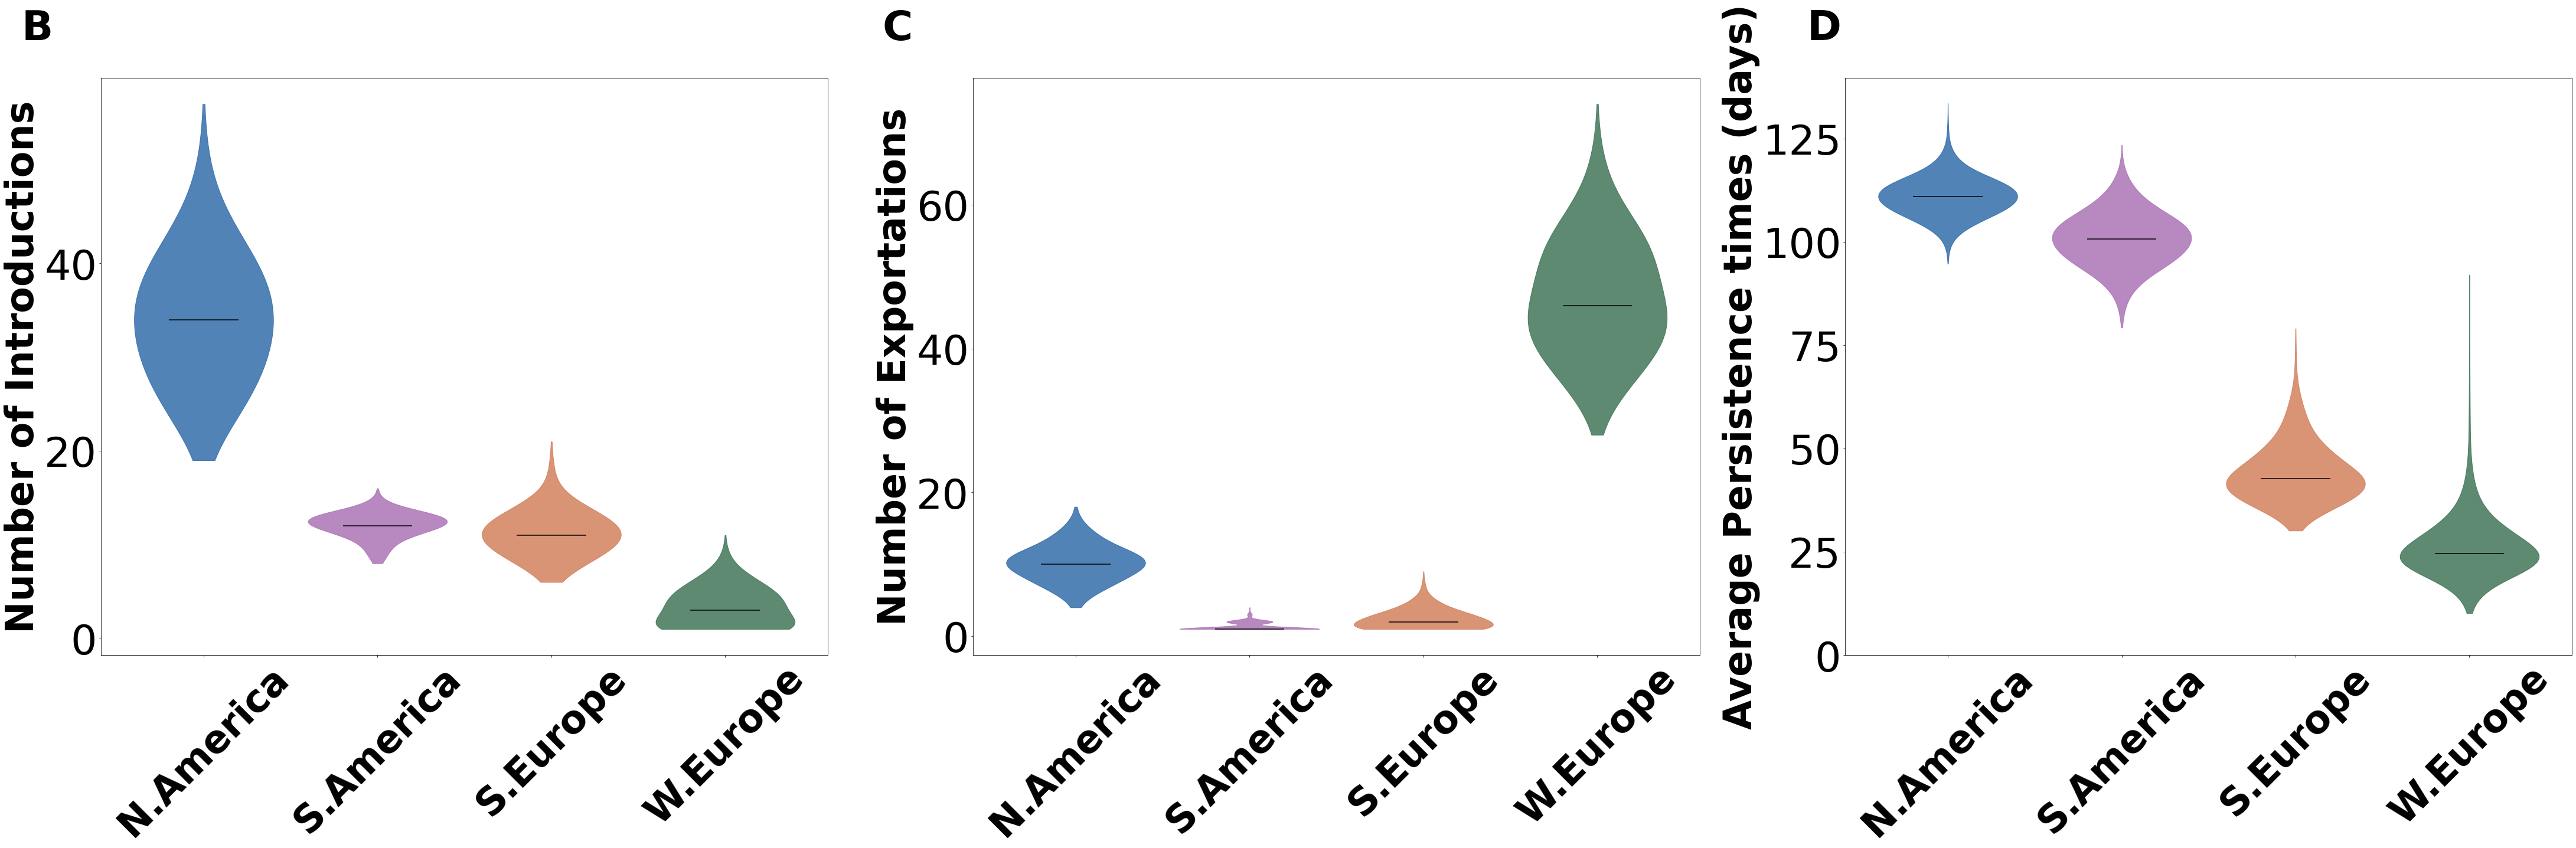

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(75, 18), facecolor='w')
#fig.suptitle('Publication Style Lettering', fontsize=30, fontweight='bold', x=0.05, y=1.05)
region_list = ["N.America", "S.America", "S.Europe", "W.Europe"]

# First plot
pos = []
for index, place in enumerate(mig_dict_imports.keys()):


    violin_plot = axs[0].violinplot(mig_dict_imports[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.6, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

divisions = list(mig_dict_imports.keys())
axs[0].set_xticks(pos)
axs[0].set_xticklabels(region_list,  fontsize=65,rotation=45, fontweight='bold')
axs[0].set_ylabel("Number of Introductions", fontsize=65, fontweight='bold')
axs[0].tick_params(axis='y', labelsize=70)

# Second plot
pos = []
for index, place in enumerate(mig_dict_exports.keys()):
    print(place, np.quantile(mig_dict_exports[place], 0.25))
    print( place, np.quantile(mig_dict_exports[place], 0.5))
    print(place, np.quantile(mig_dict_exports[place], 0.75))
    violin_plot = axs[1].violinplot(mig_dict_exports[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

divisions = list(mig_dict_exports.keys())
axs[1].set_xticks(pos)
axs[1].set_xticklabels(region_list,  fontsize=65,rotation=45, fontweight='bold')
axs[1].set_ylabel("Number of Exportations", fontsize=65, fontweight='bold')
axs[1].tick_params(axis='y', labelsize=70)

# Third plot
pos = []
for index, place in enumerate(persist_dict.keys()):
    print(place, np.quantile(persist_dict[place], 0.25))
    print(place, np.quantile(persist_dict[place], 0.5))
    print(place, np.quantile(persist_dict[place], 0.75))
    violin_plot = axs[2].violinplot(persist_dict[place], positions=[index], widths=0.8,
                                    showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    violin_plot["cmedians"].set_edgecolor("black")
    pos.append(index)

countries = list(persist_dict.keys())
axs[2].set_xticks(pos)
axs[2].set_xticklabels(region_list, fontsize=65,rotation=45, fontweight='bold')
axs[2].set_ylabel("Average Persistence times (days)", fontsize=65, fontweight='bold')
axs[2].tick_params(axis='y', labelsize=70)
axs[2].set_ylim(bottom=0)


# Add publication style lettering in the upper left corner
fig.text(0.1, 0.93, "B", fontsize=70, fontweight='bold')
fig.text(0.37, 0.93, "C", fontsize=70, fontweight='bold')
fig.text(0.66, 0.93, "D", fontsize=70, fontweight='bold')

plt.savefig('../figures/1000_dta_region_combined.png', dpi=300, bbox_inches='tight')
plt.show()


## repeat for MASCOT

In [18]:
trees =  "/Users/mparedes/Desktop/mpox_rhino/300_region_glm_air_travel.fixed_region_300.trees"

In [19]:
all_trees = trees
burnin_percent = 0.2
taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_55650/3838516127.py:8: DeprecationWarning: 'U' mode is deprecated
  with open(trees, 'rU') as infile:
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_55650/173367558.py:2: DeprecationWarning: 'U' mode is deprecated
  with open(tree_path, 'rU') as infile:


4165.6


In [20]:
migrations_df = run_mig_counts(all_trees, traitType = "max")

this took 519.4094910621643 seconds ( 8.656824851036072  minutes) to run on 16663 trees


In [21]:
imports = migrations_df.groupby(["child_host", "tree_number"])['migration_event_number'].count().reset_index()
exports = migrations_df.groupby(["parent_host", "tree_number"])['migration_event_number'].count().reset_index()

imports.index = imports.child_host
exports.index = exports.parent_host

#mig_dict = {}
mig_dict_imports={x:[] for x in imports["child_host"].unique()}
mig_dict_exports={x:[] for x in exports["parent_host"].unique()}

for items in imports.index.unique():
    mig_dict_imports[items].append(imports.loc[items,"migration_event_number"].values)
    mig_dict_exports[items].append(exports.loc[items,"migration_event_number"].values)

In [22]:

colors = {"CentralEurope":"#D0A854",
          "NorthAmerica":"#2664A5",
          "SouthAmerica":"#A76BB1",
          "SouthernEurope":"#D07954",
          "WesternEurope":"#356D4C",
          "ancestor": "#B9B9B9"
         }

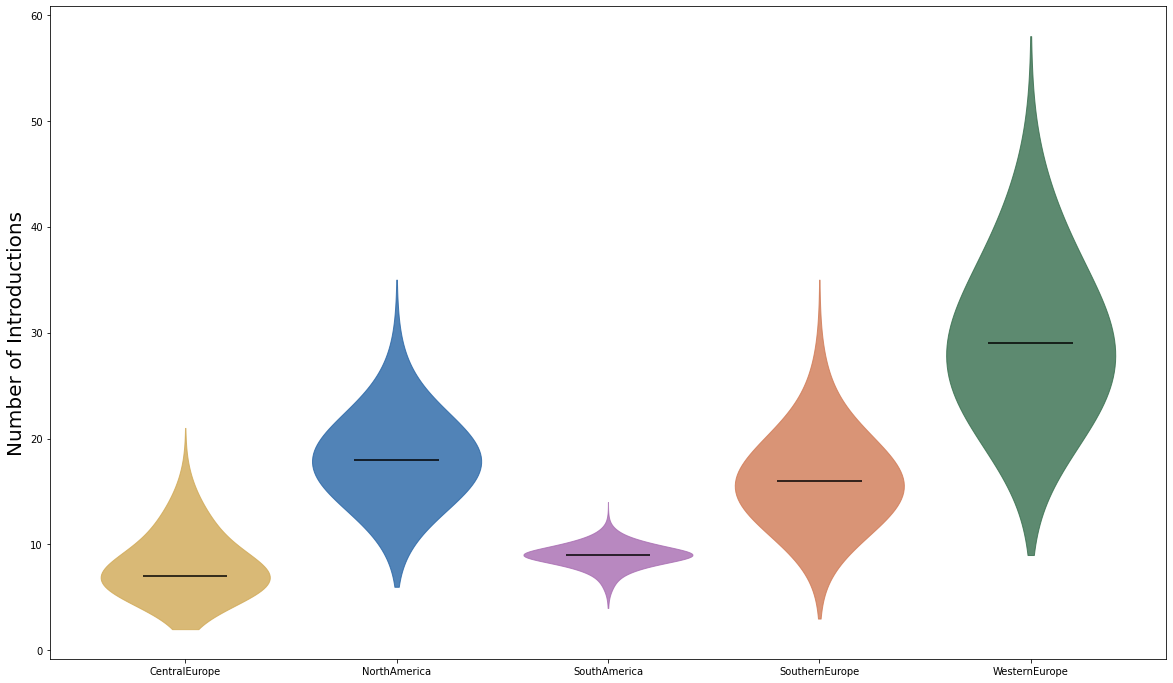

In [23]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(mig_dict_imports.keys()):
    

    violin_plot = axs.violinplot(mig_dict_imports[place], positions =[index], widths=0.8,
                      showmedians=True, bw_method=0.6, showextrema= False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    #violin_plot["cmins"].set_edgecolor("black")
    #violin_plot["cmaxes"].set_edgecolor("black")
    #violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

divisions = list(mig_dict_imports.keys())
axs.set_xticks(pos)
axs.set_xticklabels(divisions)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Number of Introductions", size=20)
plt.savefig('../figures/glm_region_intros.png',dpi=300,bbox_inches='tight')


plt.show()
    


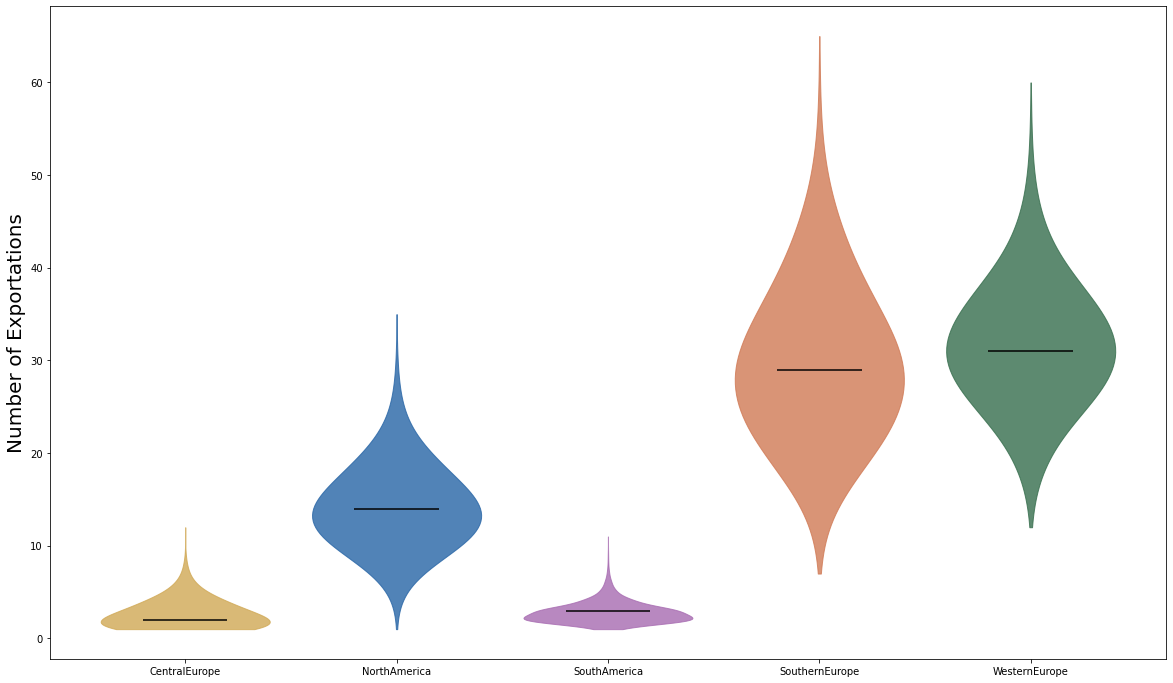

In [24]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(mig_dict_exports.keys()):
    

    violin_plot = axs.violinplot(mig_dict_exports[place], positions =[index], widths=0.8,
                      showmedians=True, bw_method=0.5, showextrema= False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    #violin_plot["cmins"].set_edgecolor("black")
    #violin_plot["cmaxes"].set_edgecolor("black")
    #violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

divisions = list(mig_dict_exports.keys())
axs.set_xticks(pos)
axs.set_xticklabels(divisions)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Number of Exportations", size=20)
plt.savefig('../figures/glm_region_exports.png',dpi=300,bbox_inches='tight')


plt.show()
    


## now do glm persistence

In [25]:
start_time = time.time()

with open(trees, "r") as infile:
    
    tree_counter = 0
    trees_processed = 0
    persistence_dict = {}
    
    for line in infile:
       # print(line)
        if 'tree STATE_' in line:
            tree_counter += 1
            

            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                tree.setAbsoluteTime(2023.0068)
                trees_processed += 1

            # iterate through the tree and pull out all migration events
                persistence_dict[tree_counter] =  estimate_persistence(tree, "max")
            
# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
persistence_df = pd.DataFrame.from_dict({(i,j): persistence_dict[i][j] 
                           for i in persistence_dict.keys() 
                           for j in persistence_dict[i].keys()},
                       orient='index')

persistence_df
persistence_df.reset_index(inplace=True)
persistence_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
persistence_df.head(5)

this took 552.2819771766663 seconds ( 9.204699619611104  minutes) to run on 16663 trees


,tree_number,migration_event_number,type,migration date,tip date,persistance,tip_name,parent_host,child_host
0,4166,1,WesternEurope-to-CentralEurope,2022.357796,2022.393101,0.035305,2022/2SLO_CentralEurope_2022-05-24,WesternEurope,CentralEurope
1,4166,2,SouthernEurope-to-WesternEurope,2022.156026,2022.667074,0.511048,MPXV/Germany/2022/RKI424_WesternEurope_2022-09-01,SouthernEurope,WesternEurope
2,4166,3,WesternEurope-to-SouthernEurope,2022.434168,2022.584882,0.150715,Monkeypox/PT0437/2022_SouthernEurope_2022-08-02,WesternEurope,SouthernEurope
3,4166,4,SouthernEurope-to-WesternEurope,2022.156026,2022.415019,0.258994,MPXV/Germany/2022/RKI526_WesternEurope_2022-06-01,SouthernEurope,WesternEurope
4,4166,5,SouthernEurope-to-WesternEurope,2022.156026,2022.508170,0.352144,hMPXV/Austria/MUW1531848/2022_WesternEurope_20...,SouthernEurope,WesternEurope


In [26]:
persist = persistence_df.groupby(["child_host", "tree_number"])['persistance'].mean().reset_index()
persist['persistance'] = persist['persistance'].map(convert_persistence)
persist['persistance'] = persist['persistance'].div(86400) #calculating number of days from seconds
persist.index = persist.child_host


persist_dict={x:[] for x in persist["child_host"].unique()}

for items in persist.index.unique():
    persist_dict[items].append(persist.loc[items,"persistance"].values)
    


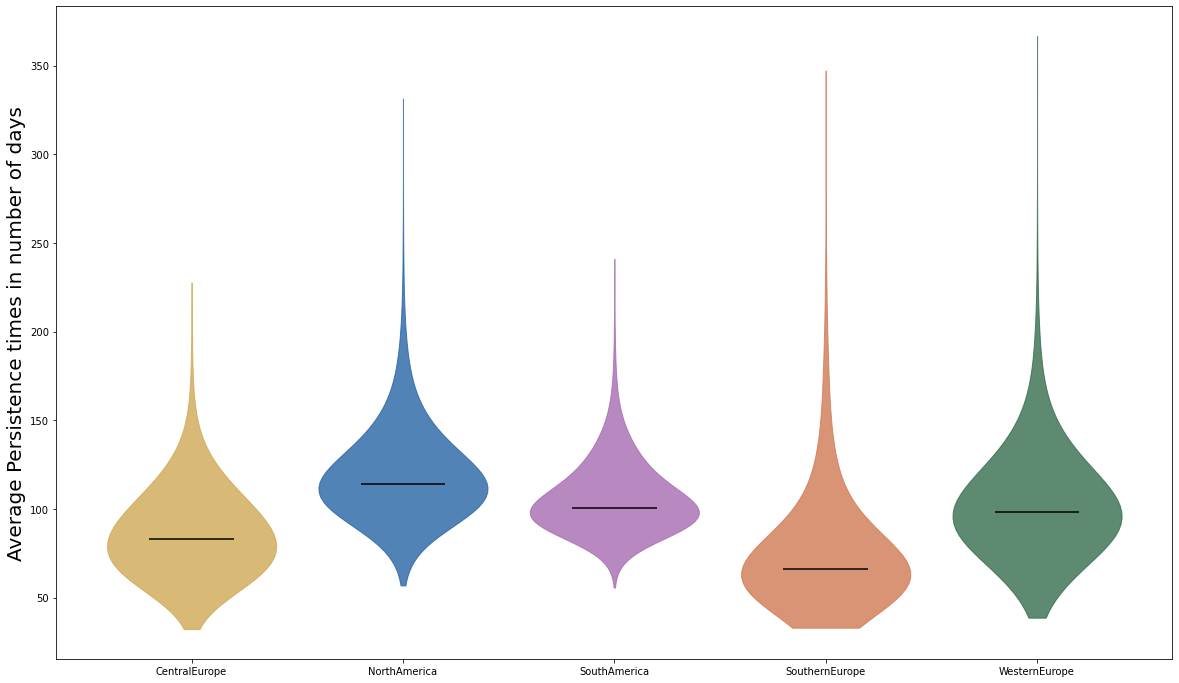

In [27]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(persist_dict.keys()):
    

    violin_plot = axs.violinplot(persist_dict[place], positions =[index], widths=0.8,
                      showmedians=True, bw_method=0.6, showextrema= False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    #violin_plot["cmins"].set_edgecolor("black")
    #violin_plot["cmaxes"].set_edgecolor("black")
    #violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

countries = list(persist_dict.keys())
axs.set_xticks(pos)
axs.set_xticklabels(countries)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Average Persistence times in number of days", size=20)
plt.savefig('../figures/glm_region_persistence.png',dpi=300,bbox_inches='tight')


plt.show()

In [94]:
## now do glm but by countries

In [95]:
trees = "/Users/mparedes/Desktop/mpox_rhino/300_glm_country_masked.fixed_300.trees"

In [96]:
all_trees = trees
burnin_percent = 0.2
taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_7437/3838516127.py:8: DeprecationWarning: 'U' mode is deprecated
  with open(trees, 'rU') as infile:
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_7437/173367558.py:2: DeprecationWarning: 'U' mode is deprecated
  with open(tree_path, 'rU') as infile:


630.2


In [97]:
migrations_df = run_mig_counts(all_trees, traitType = "max")

this took 109.81781029701233 seconds ( 1.8302968382835387  minutes) to run on 2521 trees


In [98]:
imports = migrations_df.groupby(["child_host", "tree_number"])['migration_event_number'].count().reset_index()
exports = migrations_df.groupby(["parent_host", "tree_number"])['migration_event_number'].count().reset_index()

imports.index = imports.child_host
exports.index = exports.parent_host

#mig_dict = {}
mig_dict_imports={x:[] for x in imports["child_host"].unique()}
mig_dict_exports={x:[] for x in exports["parent_host"].unique()}

for items in imports.index.unique():
    mig_dict_imports[items].append(imports.loc[items,"migration_event_number"].values)
    mig_dict_exports[items].append(exports.loc[items,"migration_event_number"].values)

In [99]:
colors = {"Canada":"#133253",
          "USA":"#2664A5",
        
          
          # greens
          "UnitedKingdom":"#1C3828",
          "Germany":"#356D4C",
          "Switzerland":"#81A48F",
          "Austria":"#B3C8BC",
          "France":"#CCDAD2",

          "Belgium":"#438B62",
          #"Netherlands":"#60B684",

          
          # yellows
          "Slovakia":"#D0A854",
          "Slovenia":"#EEC060",

          
          # oranges
          "Italy":"#D07954",
          "Portugal":"#EEA160",
          "Spain":"#F4C49C",
          
          # purples
          "Colombia":"#2D1E45",
          "Peru":"#695B82",
          "ancestor":'grey'

          
          # reds

          #"Finland":"#C5656E"
         }


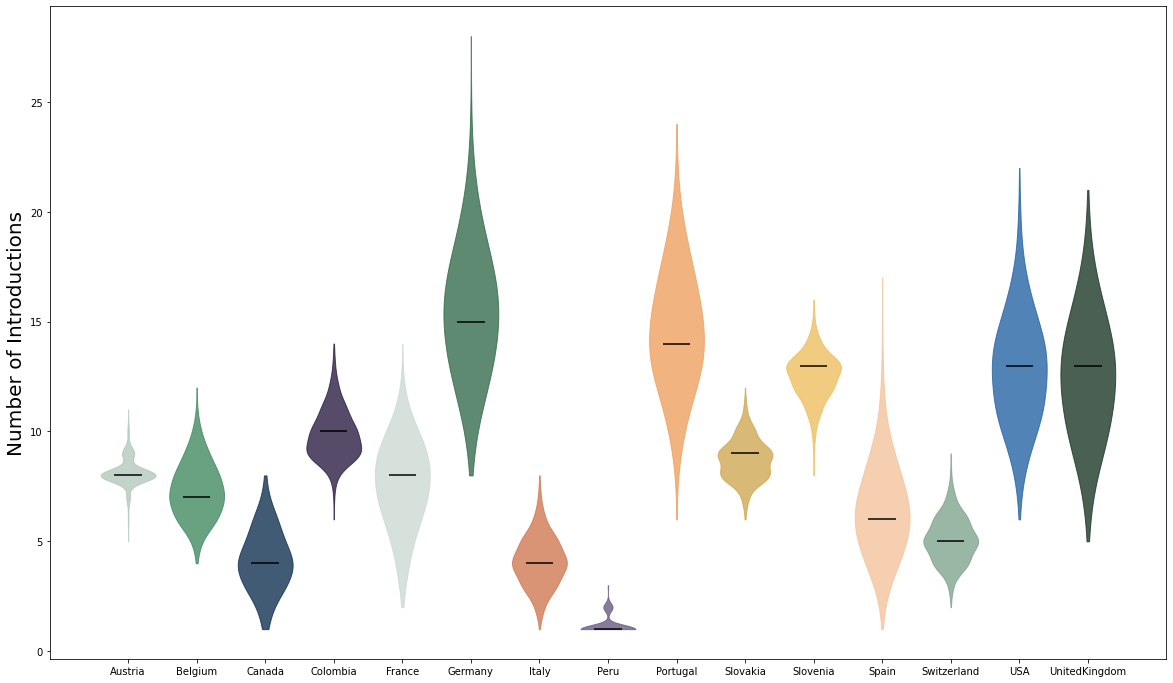

In [100]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(mig_dict_imports.keys()):
    

    violin_plot = axs.violinplot(mig_dict_imports[place], positions =[index], widths=0.8,
                      showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    #violin_plot["cmins"].set_edgecolor("black")
    #violin_plot["cmaxes"].set_edgecolor("black")
    #violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

divisions = list(mig_dict_imports.keys())
axs.set_xticks(pos)
axs.set_xticklabels(divisions)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Number of Introductions", size=20)
plt.savefig('../figures/glm_country_intros.png',dpi=300,bbox_inches='tight')


plt.show()
    


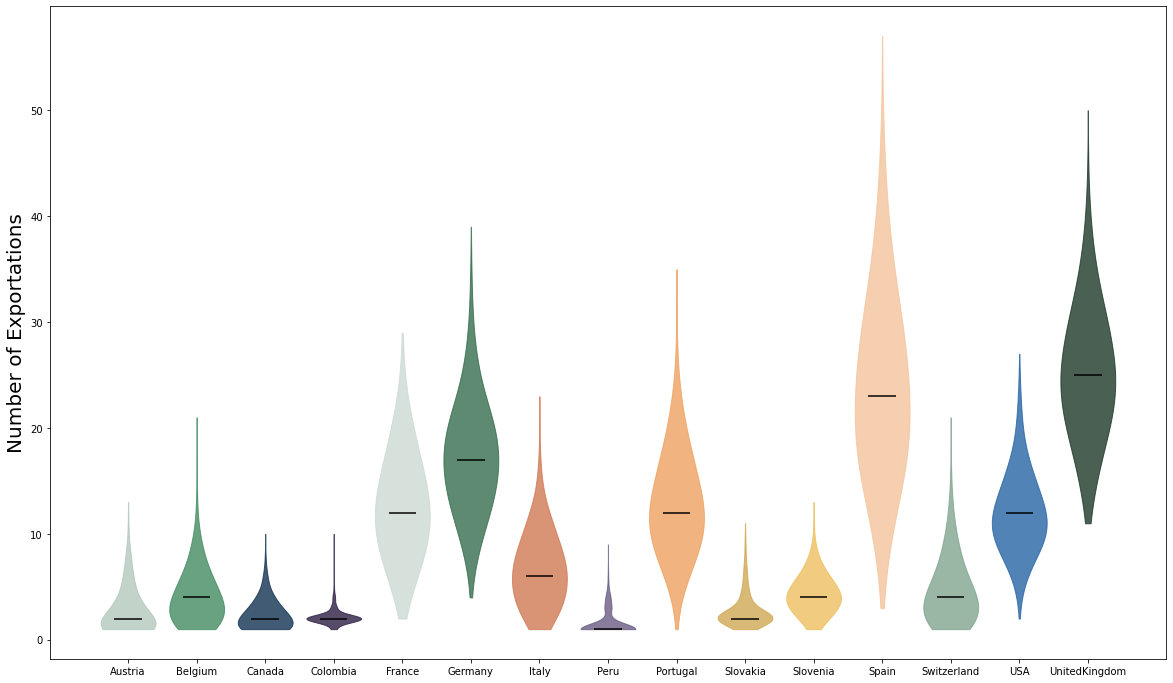

In [101]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(mig_dict_exports.keys()):
    

    violin_plot = axs.violinplot(mig_dict_exports[place], positions =[index], widths=0.8,
                      showmedians=True, bw_method=0.5, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
    #violin_plot["cmins"].set_edgecolor("black")
   # violin_plot["cmaxes"].set_edgecolor("black")
   # violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

divisions = list(mig_dict_exports.keys())
axs.set_xticks(pos)
axs.set_xticklabels(divisions)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Number of Exportations", size=20)
plt.savefig('../figures/glm_country_exports.png',dpi=300,bbox_inches='tight')


plt.show()
    


In [102]:
start_time = time.time()

with open(trees, "r") as infile:
    
    tree_counter = 0
    trees_processed = 0
    persistence_dict = {}
    
    for line in infile:
       # print(line)
        if 'tree STATE_' in line:
            tree_counter += 1
            

            if tree_counter > burnin:
                temp_tree = StringIO(taxa_lines + line)
                tree = bt.loadNexus(temp_tree, tip_regex='_([0-9\-]+)$')
                tree.setAbsoluteTime(2023.0068)
                trees_processed += 1

            # iterate through the tree and pull out all migration events
                persistence_dict[tree_counter] =  estimate_persistence(tree, "max")
            
# print the amount of time this took
total_time_seconds = time.time() - start_time
total_time_minutes = total_time_seconds/60
print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
persistence_df = pd.DataFrame.from_dict({(i,j): persistence_dict[i][j] 
                           for i in persistence_dict.keys() 
                           for j in persistence_dict[i].keys()},
                       orient='index')

persistence_df
persistence_df.reset_index(inplace=True)
persistence_df.rename(columns={'level_0': 'tree_number', 'level_1': 'migration_event_number'}, inplace=True)
persistence_df.head(5)

this took 112.30354523658752 seconds ( 1.8717257539431253  minutes) to run on 2521 trees


,tree_number,migration_event_number,type,migration date,tip date,persistance,tip_name,parent_host,child_host
0,631,1,Spain-to-Slovenia,2022.090755,2022.393101,0.302347,2022/2SLO_Slovenia_2022-05-24,Spain,Slovenia
1,631,2,UnitedKingdom-to-Spain,2022.001952,2022.382142,0.380190,4061_Spain_2022-05-20,UnitedKingdom,Spain
2,631,3,UnitedKingdom-to-Spain,2022.001952,2022.428718,0.426766,8887_Spain_2022-06-06,UnitedKingdom,Spain
3,631,4,Spain-to-Portugal,2022.377127,2022.527348,0.150221,Monkeypox/PT0382/2022_Portugal_2022-07-12,Spain,Portugal
4,631,5,Spain-to-Austria,2022.389630,2022.508170,0.118540,hMPXV/Austria/MUW1531848/2022_Austria_2022-07-05,Spain,Austria


In [103]:
persist = persistence_df.groupby(["child_host", "tree_number"])['persistance'].mean().reset_index()
persist['persistance'] = persist['persistance'].map(convert_persistence)
persist['persistance'] = persist['persistance'].div(86400) #calculating number of days from seconds
persist.index = persist.child_host


persist_dict={x:[] for x in persist["child_host"].unique()}

for items in persist.index.unique():
    persist_dict[items].append(persist.loc[items,"persistance"].values)
    


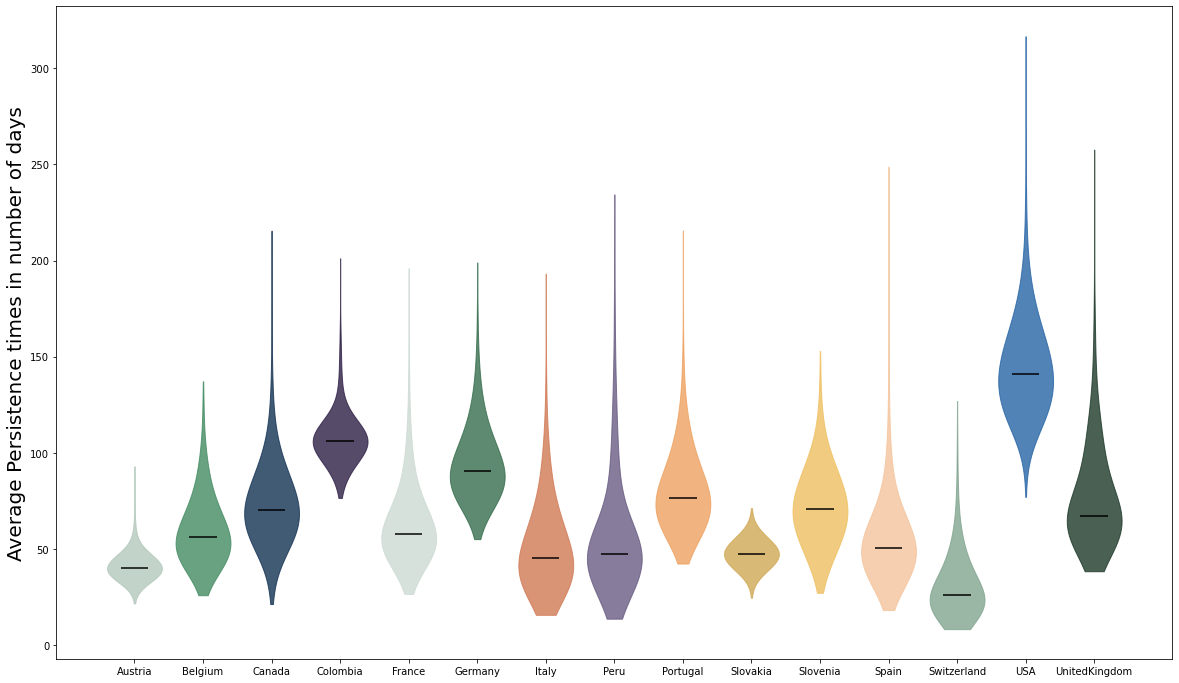

In [105]:
fig,axs = plt.subplots(figsize=(20,12),facecolor='w')
pos = []
for index, place in enumerate(persist_dict.keys()):
    

    violin_plot = axs.violinplot(persist_dict[place], positions =[index], widths=0.8,
                      showmedians=True, bw_method=0.6, showextrema=False)
    violin_plot["bodies"][0].set_facecolor(colors[place])
    violin_plot["bodies"][0].set_edgecolor(colors[place])
    violin_plot["bodies"][0].set_alpha(.8)
   # violin_plot["cmins"].set_edgecolor("black")
   # violin_plot["cmaxes"].set_edgecolor("black")
   # violin_plot["cbars"].set_edgecolor("black")
    violin_plot["cmedians"].set_edgecolor("black")

    pos.append(index)

countries = list(persist_dict.keys())
axs.set_xticks(pos)
axs.set_xticklabels(countries)
#axs.set_xlabel("Country", size=20)
axs.set_ylabel("Average Persistence times in number of days", size=20)
plt.savefig('../figures/300_glm_country_persistence.png',dpi=300,bbox_inches='tight')


plt.show()